In [1]:
from skimage import color
from skimage import io
import SimpleITK as sitk
import sys, os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
print(sitk.Version())

SimpleITK Version: 1.2.0rc2.dev1162-g2a79d (ITK 4.13)
Compiled: Apr  2 2019 10:45:53



In [2]:
""" load fixed image and moving image (take fixed as standard, convert moving image into results)"""
fixedImage = sitk.ReadImage("/pylon5/ac5616p/lisahou/hvsmr/data/axial_cropped_train/training_axial_crop_pat0.nii")
movingImage = sitk.ReadImage("/pylon5/ac5616p/lisahou/hvsmr/data/axial_cropped_train/training_axial_crop_pat1.nii")

""" translation is just linear function """
#parameterMap = sitk.GetDefaultParameterMap('translation')
#parameterMap = sitk.GetDefaultParameterMap("bspline")

elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixedImage)
elastixImageFilter.SetMovingImage(movingImage)
#elastixImageFilter.SetParameterMap(parameterMap)

""" use non-linear parameter map """
parameterMapVector = sitk.VectorOfParameterMap()
parameterMapVector.append(sitk.GetDefaultParameterMap("affine"))
parameterMapVector.append(sitk.GetDefaultParameterMap("bspline"))
elastixImageFilter.SetParameterMap(parameterMapVector)
elastixImageFilter.Execute()

""" get result and save it into nii file """
resultImage = elastixImageFilter.GetResultImage()
#transformParameterMap = elastixImageFilter.GetTransformParameterMap()
sitk.WriteImage(resultImage, "trans.nii")

In [3]:
fixedImageArray = sitk.GetArrayFromImage(fixedImage)
movingImageArray = sitk.GetArrayFromImage(movingImage)
resultImageArray = sitk.GetArrayFromImage(resultImage)

In [4]:
print(fixedImageArray.shape)
print(movingImageArray.shape)
print(resultImageArray.shape)

(141, 207, 127)
(144, 206, 127)
(141, 207, 127)


In [5]:
def myshow(img,title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()

    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]

        # the the number of components is 3 or 4 consider it an RGB image
        if c not in (3, 4):
            nda = nda[nda.shape[0] // 2, :, :]

    elif nda.ndim == 4:
        c = nda.shape[-1]

        if c not in (3, 4):
            raise RuntimeError("Unable to show 3D-vector Image")

        # take a z-slice
        nda = nda[nda.shape[0] // 2, :, :, :]

    xsize = nda.shape[1]
    ysize = nda.shape[0]

    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * xsize / dpi, (1 + margin) * ysize / dpi

    plt.figure(figsize=figsize, dpi=dpi, tight_layout=True)
    ax = plt.gca()

    extent = (0, xsize * spacing[0], ysize * spacing[1], 0)

    t = ax.imshow(nda, extent=extent, interpolation=None)

    if nda.ndim == 2:
        t.set_cmap("gray")

    if(title):
        plt.title(title)

    return plt.figure()

def myshow3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05,
             dpi=80):
    img_xslices = [img[s, :, :] for s in xslices]
    img_yslices = [img[:, s, :] for s in yslices]
    img_zslices = [img[:, :, s] for s in zslices]

    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))

    img_null = sitk.Image([0, 0], img.GetPixelID(),
                          img.GetNumberOfComponentsPerPixel())

    img_slices = []
    d = 0

    if len(img_xslices):
        img_slices += img_xslices + [img_null] * (maxlen - len(img_xslices))
        d += 1

    if len(img_yslices):
        img_slices += img_yslices + [img_null] * (maxlen - len(img_yslices))
        d += 1

    if len(img_zslices):
        img_slices += img_zslices + [img_null] * (maxlen - len(img_zslices))
        d += 1

    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen, d])
        # TO DO check in code to get Tile Filter working with vector images
        else:
            img_comps = []
            for i in range(0, img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i)
                                for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen, d]))
            img = sitk.Compose(img_comps)

    myshow(img, title, margin, dpi)
    
def resize_image(heartArray):
    #resize the image
    img_stack_sm = np.zeros((len(heartArray), height, depth))

    for idx in range(len(heartArray)):
        img = heartArray[idx, :, :]
        if is_label_data:
            img_sm = cv2.resize(img, (height, depth), interpolation=cv2.INTER_NEAREST)

        else:
            img_sm = cv2.resize(img, (height, depth), interpolation=cv2.INTER_CUBIC)
        img_stack_sm[idx, :, :] = img_sm


    img_stack_sm2 = np.zeros((width, height, depth))

    for idx in range(height):
        img = img_stack_sm[ :, idx, :]
        if is_label_data:
            img_sm = cv2.resize(img, (width, depth), interpolation=cv2.INTER_NEAREST)

        else:
            img_sm = cv2.resize(img, (width, depth), interpolation=cv2.INTER_CUBIC)
        img_stack_sm2[ :,idx, :] = img_sm
    
    return sitk.GetImageFromArray(img_stack_sm2)

/pylon5/ac5616p/lisahou/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


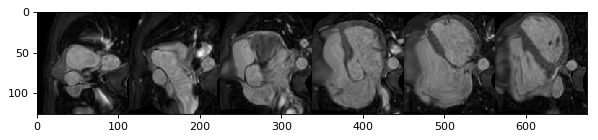

<Figure size 432x288 with 0 Axes>

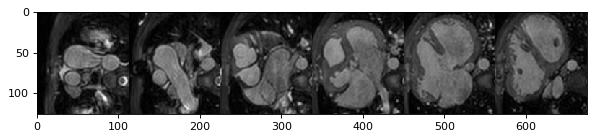

<Figure size 432x288 with 0 Axes>

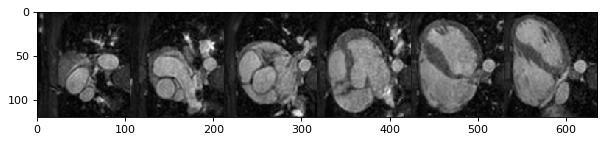

<Figure size 432x288 with 0 Axes>

In [14]:
myshow3d(resultImage, yslices=range(50, resultImage.GetSize()[1] - 50, 20))
myshow3d(fixedImage, yslices=range(50, fixedImage.GetSize()[1] - 50, 20))
myshow3d(movingImage, yslices=range(50, movingImage.GetSize()[1] - 50, 20))

In [72]:
'''
hd must be either 'index' or 'point'
'''
def generate_points(x_range=[], y_range=[], z_range=[], filename='test.pts', hd='index'):
    assert(hd=='index' or hd=='point')
    res = np.zeros((len(x_range) * len(y_range) * len(z_range), 3))
    fr = open(filename, 'w')
    fr.write(hd + '\n' + str(len(x_range) * len(y_range) * len(z_range)))
    num_row = 0
    for i in range(len(x_range)):
        for j in range(len(y_range)):
            for k in range(len(z_range)):
                x = np.array([x_range[i], y_range[j], z_range[k]]).astype('float')
                s = np.array2string(x, formatter={'float_kind':lambda x: "%.1f" % x}).lstrip('[').rstrip(']')
                fr.write('\n' + s)
                res[num_row] = x
                num_row += 1
    fr.close()
    return res.astype('int')

In [74]:
x_range = np.array(range(50, 52))
y_range = np.array(range(50, 52))
z_range = np.array(range(50, 52))
points = generate_points(x_range, y_range, z_range)

In [75]:
i=points[:, 0].reshape(2, 2, 2)
j=points[:, 1].reshape(2, 2, 2)
k=points[:, 2].reshape(2, 2, 2)

original_patch = fixedImageArray[i, j, k]
print(original_patch)

[[[1665. 1672.]
  [1690. 1730.]]

 [[1552. 1574.]
  [1679. 1715.]]]


In [29]:
transformixImageFilter = sitk.TransformixImageFilter()
# transformParameterMap = sitk.ElastixImageFilter().ReadParameterFile("TransformParameters.0.txt")
transformixImageFilter.SetTransformParameterMap(elastixImageFilter.GetTransformParameterMap())
# transformixImageFilter.SetTransformParameterMap(transformParameterMap)
transformixImageFilter.SetFixedPointSetFileName("test.pts")
transformixImageFilter.SetMovingImage(movingImage)
transformixImageFilter.Execute()

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f50db596f60> >

In [53]:
def get_output_points(filename='outputpoints.txt'):
    fr = open(filename, 'r')
    
    res = None
    for line in fr.readlines():
        line = line[line.index('OutputIndexFixed = ') + len('OutputIndexFixed = '):]
        line = line[:line.index('\t')].lstrip('[').rstrip(']')
        array = np.fromstring(line, dtype=int, sep=' ')
        if res is None:
            res = array.reshape(1, 3)
        else:
            res = np.concatenate((res, array.reshape(1, 3)), 0)
        
    return res

In [55]:
points = get_output_points()

In [76]:
i=points[:, 0].reshape(2, 2, 2)
j=points[:, 1].reshape(2, 2, 2)
k=points[:, 2].reshape(2, 2, 2)
movingImageArray[i, j, k]

array([[[258.15140415, 283.54334554],
        [298.35531136, 270.84737485]],

       [[234.87545788, 222.17948718],
        [264.4993895 , 224.2954823 ]]])

Remains to be done:

1. Resize images before generate patches
2. generate patches (coordinates of points) given padding size and patch size
3. resize patches
4. extract gray-scale pixel values with coordinates from fixedImage and resultImage
5. feed-forward network of U-Net and use the last layer but one output as features

In [99]:
def create_index(points, patch_size):
    i=points[:, 0].reshape(patch_size[0], patch_size[1], patch_size[2])
    j=points[:, 1].reshape(patch_size[0], patch_size[1], patch_size[2])
    k=points[:, 2].reshape(patch_size[0], patch_size[1], patch_size[2])
    return i, j, k
            
def generate_patches(fixedImage, movingImage, transformParameterMap, filename='test.pts', patch_size=[20, 20, 20], padding=20):
    fixedPatches = []
    movingPathces = []
    
    x, y, z = 0, 0, 0
    movingImageArray = sitk.GetArrayFromImage(movingImage)
    fixedImageArray = sitk.GetArrayFromImage(fixedImage)
    (x_length, y_length, z_length) = fixedImageArray.shape
    
    while x < x_length:
        while y < y_length:
            while z < z_length:
                x_range = np.array(range(x, x+patch_size[0]))
                y_range = np.array(range(y, y+patch_size[1]))
                z_range = np.array(range(z, z+patch_size[2]))
                original_points = generate_points(x_range, y_range, z_range)
                i, j, k = create_index(original_points, patch_size)
                original_patch = fixedImageArray[i, j, k]
                
                transformixImageFilter = sitk.TransformixImageFilter()
                transformixImageFilter.SetTransformParameterMap(transformParameterMap)
                transformixImageFilter.SetFixedPointSetFileName(filename)
                transformixImageFilter.SetMovingImage(movingImage)
                transformixImageFilter.Execute()
                
                transformed_points = get_output_points()
                if indexIsValid(transformed_points) == False:
                    continue
                i, j, k = create_index(transformed_points)
                transformed_patch = movingImageArray[i, j, k]
                
                fixedPatches += [original_patch]
                movingPatches += [transformed_patch]
                
                z += padding
            y += padding
        z += padding
    return fixedPatches, movingPatches
        
def indexIsValid(points):
    return (points.flatten()<0).sum() == 0

In [100]:
generate_patches(fixedImage, movingImage, elastixImageFilter.GetTransformParameterMap(), )

SystemError: <built-in function TransformixImageFilter_Execute> returned a result with an error set